# Text Classification with Dimensionality Reduction  
### *Airline Tweet Sentiment Analysis using TF-IDF, Naive Bayes, SVD, PCA & Logistic Regression*

---

## Group 2 Members
**Albright Maduka Ifechukwude – 9053136**  
**Abdullahi Abdirizak Mohamed – 9082466**  
**Kamamo Lesley Wanjiku - 8984971**

---

## Introduction

This project explores the task of **binary text classification** using real-world airline customer tweets.  
Building on the techniques outlined in our course materials, we implement a complete Natural Language Processing (NLP) workflow that transforms raw textual data into meaningful numerical features and analyzes how different models perform on sentiment classification.

We focus on:
- Converting tweets into TF-IDF feature vectors  
- Reducing feature dimensionality using **SVD (TruncatedSVD)** and **PCA**  
- Comparing baseline and advanced machine learning models  
- Evaluating performance using confusion matrices and standard classification metrics  

To align with the project requirements, we:
- Select **two airlines** (United Airlines and Delta Airlines)  
- Reduce the sentiment labels to **positive vs negative** (binary classification)  
- Apply normalization and text preprocessing to clean noisy tweet data  
- Train three models:
  1. **Naive Bayes using TF-IDF** (baseline)  
  2. **Logistic Regression using SVD-reduced features**  
  3. **Logistic Regression using PCA-reduced features**  

This introduction serves as the foundation for the detailed analysis, modeling, and evaluation presented in the following sections of the notebook.

---


## Importing Libraries

In this section, we import all the necessary Python libraries


In [2]:
# 0. Imports
import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Displaying the Original Dataset

Before cleaning or preprocessing, we first load and inspect the full dataset to 
understand its structure, the number of columns, and the presence of missing values. 
This step helps us identify which fields are useful for text classification and which 
contain irrelevant or incomplete information.

In [3]:
# Load full dataset
df = pd.read_csv("data/Tweets.csv")

# 1. Display first 5 rows
print(" Original Dataset (First 5 Rows):")
display(df.head())

# 2. Display full dataset shape
print("\n Original Dataset Shape (rows, columns):")
print(df.shape)

# 3. Display dataset info (column names, non-null counts, dtypes)
print("\n Original Dataset Info:")
print(df.info())

# 4. Count missing values per column
print("\n Original Missing Values Per Column:")
print(df.isnull().sum())


 Original Dataset (First 5 Rows):


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)



 Original Dataset Shape (rows, columns):
(14640, 15)

 Original Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-n

### Reflection

We began by displaying the full original dataset to understand its structure and identify missing or irrelevant columns. The dataset includes 15 fields, many of which contain incomplete information. This inspection step helps clarify which features are required for text classification and which can be removed. It establishes a clear baseline before applying any cleaning or preprocessing.

## 2. Selecting Essential Columns and Removing Missing Values

After reviewing the full dataset structure, we now focus on keeping only the fields 
required for sentiment classification. The essential columns for this project are:

- `airline` — identifies which airline the tweet refers to  
- `airline_sentiment` — the sentiment label  
- `text` — the tweet content used for TF-IDF  

Several other columns contain extensive missing values and are not needed for our NLP 
workflow, so we remove them. We also drop rows missing any of the essential fields to 
ensure clean, consistent data for modeling.


In [4]:
# Keep only essential columns for classification
df_clean = df[['airline', 'airline_sentiment', 'text']]

# Drop rows with missing values in these key columns
df_clean = df_clean.dropna(subset=['airline', 'airline_sentiment', 'text'])

# Display the first 5 rows of the cleaned dataset
print(" Cleaned Dataset Preview:")
display(df_clean.head())

# Display the new dataset shape
print("\n Cleaned Dataset Shape:")
print(df_clean.shape)

# Display missing values after cleaning
print("\n Missing Values After Cleaning:")
print(df_clean.isnull().sum())


 Cleaned Dataset Preview:


,airline,airline_sentiment,text
0,Virgin America,neutral,@VirginAmerica What @dhepburn said.
1,Virgin America,positive,@VirginAmerica plus you've added commercials t...
2,Virgin America,neutral,@VirginAmerica I didn't today... Must mean I n...
3,Virgin America,negative,@VirginAmerica it's really aggressive to blast...
4,Virgin America,negative,@VirginAmerica and it's a really big bad thing...



 Cleaned Dataset Shape:
(14640, 3)

 Missing Values After Cleaning:
airline              0
airline_sentiment    0
text                 0
dtype: int64


### Reflection

We reduced the dataset to the three key fields required for this project: airline, 
sentiment label, and tweet text. Non-essential columns with missing values were removed 
to avoid noise and simplify preprocessing. Rows missing any essential field were dropped 
to ensure data consistency. The cleaned dataset is now complete and ready for filtering 
and further text processing.

## 3. Filtering Airlines and Creating Multi-Class Sentiment Labels

To align the dataset with our project requirements, we focus on tweets from two airlines:
**United** and **Delta**. This selection ensures enough data for a meaningful comparison 
between the airlines. We keep all three sentiment categories — negative, positive, and 
neutral — and map them to numerical labels to support machine learning algorithms:

- 0 = Negative  
- 1 = Positive  
- 2 = Neutral  

We also balance the dataset so that each class is equally represented, which helps 
reduce model bias and improves evaluation reliability.

In [5]:
# Filter to only United and Delta tweets
df_filtered = df_clean[df_clean['airline'].isin(['United', 'Delta'])]

# Map sentiment labels to numerical values
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
df_filtered['label'] = df_filtered['airline_sentiment'].map(label_map)

# Check distribution before balancing
print("Class Distribution Before Balancing:")
print(df_filtered['label'].value_counts())

# Balance to ~2000 samples (≈ 600 per class)
df_balanced = df_filtered.groupby('label').apply(
    lambda x: x.sample(600, random_state=42)
)

# Remove groupby index
df_balanced = df_balanced.reset_index(drop=True)

# Show balanced distribution
print("\n Class Distribution After Balancing:")
print(df_balanced['label'].value_counts())

# Preview cleaned & filtered dataset
display(df_balanced.head())

Class Distribution Before Balancing:
label
0    3588
2    1420
1    1036
Name: count, dtype: int64

 Class Distribution After Balancing:
label
0    600
1    600
2    600
Name: count, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_2796\886067660.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = df_filtered['airline_sentiment'].map(label_map)
C:\Users\USER\AppData\Local\Temp\ipykernel_2796\886067660.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_filtered.groupby('label').apply(


,airline,airline_sentiment,text,label
0,Delta,negative,@JetBlue Finally starting to come out. 40 minu...,0
1,Delta,negative,"@JetBlue When I got your alert, I immediately ...",0
2,United,negative,@united thanks kp but luckily my transfer has ...,0
3,United,negative,@united flt 1249 Cancelled Flightled and I get...,0
4,Delta,negative,@JetBlue just learning about your famous apolo...,0


### Reflection

We filtered the dataset to include only United and Delta tweets to enable a focused 
comparison. All three sentiment categories were retained and converted into numerical 
labels for machine learning compatibility. The dataset was then balanced to ensure equal 
representation across sentiment classes. This prepares a clean and fair dataset for 
text preprocessing and model development.

## 4. Text Cleaning and Normalization

Raw tweets often contain noise such as URLs, user mentions, punctuation, emojis, and 
inconsistent spacing. To prepare the text for TF-IDF feature extraction and machine 
learning models, we normalize the content by:

- Lowercasing all text  
- Removing URLs  
- Removing @mentions  
- Removing punctuation and non-alphabet characters  
- Removing extra whitespace  

This step ensures consistent formatting and reduces noise, improving the quality 
of the features extracted later.

In [6]:
# Text normalization function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+", " ", text)  # remove URLs
    text = re.sub(r"@\w+", " ", text)  # remove mentions
    text = re.sub(r"[^a-z\s]", " ", text)  # keep only letters and spaces
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

# Apply cleaning to all tweets
df_balanced['clean_text'] = df_balanced['text'].apply(clean_text)

# Display preview of cleaned text
print("Cleaned Text Preview:")
df_balanced[['text', 'clean_text']].head()


Cleaned Text Preview:


,text,clean_text
0,@JetBlue Finally starting to come out. 40 minu...,finally starting to come out minutes and no co...
1,"@JetBlue When I got your alert, I immediately ...",when i got your alert i immediately started lo...
2,@united thanks kp but luckily my transfer has ...,thanks kp but luckily my transfer has maintena...
3,@united flt 1249 Cancelled Flightled and I get...,flt cancelled flightled and i get email am wha...
4,@JetBlue just learning about your famous apolo...,just learning about your famous apology in soc...


### Reflection

We normalized the tweet text to remove noise such as URLs, mentions, punctuation, 
and inconsistent casing. This cleaning step ensures that TF-IDF will generate a more 
accurate and meaningful vocabulary. Reducing noise improves feature quality and 
strengthens the performance of downstream machine learning models.

## 5. Train–Test Split (75% / 25%)

To evaluate our models effectively, we split the dataset into training and testing sets. 
Following the project requirement, we use a 75% training and 25% testing ratio. We also 
apply stratification to ensure that all three sentiment classes (negative, positive, 
neutral) remain evenly represented in both sets. This prevents class imbalance from 
affecting model performance and ensures a fair evaluation.

In [7]:
# Define features and labels
X = df_balanced['clean_text']
y = df_balanced['label']

# 75/25 split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 1350
Testing samples: 450


### Reflection

We split the cleaned and balanced dataset into training and testing sets using a 75/25 
ratio, following the project requirement. Stratification was applied to maintain equal 
representation of all sentiment classes in both sets. This ensures reliable evaluation 
of model performance. The resulting split provides a solid foundation for feature 
extraction and model training.

## 6. TF-IDF Feature Extraction

To convert the cleaned tweet text into numerical features suitable for machine learning,
we apply TF-IDF (Term Frequency–Inverse Document Frequency). TF-IDF assigns weights to 
words based on how often they appear in a tweet relative to how rare they are across 
the dataset. This representation captures important textual patterns while reducing the 
impact of very common words.

We use up to 5000 features and include both unigrams and bigrams to capture short 
phrases. TF-IDF output will serve as the input for our baseline Naive Bayes model and 
for dimensionality reduction (SVD and PCA) in later steps.

In [8]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words='english'
)

# Fit on training data, transform both training and test sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Training Matrix Shape:", X_train_tfidf.shape)
print("TF-IDF Testing Matrix Shape:", X_test_tfidf.shape)

TF-IDF Training Matrix Shape: (1350, 5000)
TF-IDF Testing Matrix Shape: (450, 5000)


### Reflection

TF-IDF was applied to transform the cleaned tweet text into numerical feature vectors 
using up to 5000 terms and a mix of unigrams and bigrams. This representation highlights 
important words while reducing the influence of common ones. The resulting sparse 
matrices form the foundation for our baseline Naive Bayes model and later dimensionality 
reduction steps.

## 7. Baseline Model: Naive Bayes Classification

Naive Bayes serves as our baseline model for sentiment classification using the 
TF-IDF feature matrix. It is well suited for text data due to its ability to 
handle high-dimensional sparse features efficiently. In this step, we train a 
Multinomial Naive Bayes classifier, generate predictions on the test set, and 
evaluate performance using accuracy, precision, recall, F1-score, and a confusion 
matrix. This baseline provides a reference point for later comparisons with models 
that use dimensionality reduction (SVD and PCA).

 Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.79      0.67       150
           1       0.76      0.74      0.75       150
           2       0.68      0.47      0.55       150

    accuracy                           0.66       450
   macro avg       0.67      0.66      0.66       450
weighted avg       0.67      0.66      0.66       450

 Confusion Matrix:
 [[118  14  18]
 [ 24 111  15]
 [ 58  22  70]]


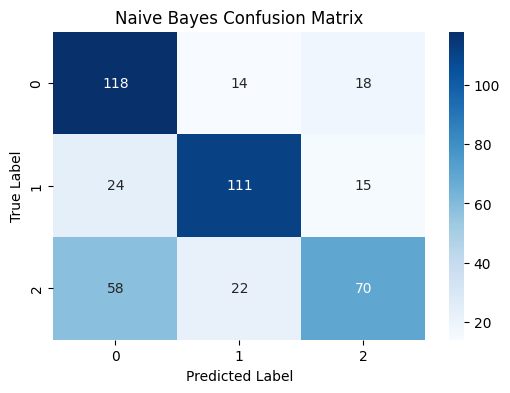

TP, TN, FP, FN for each sentiment class:

Negative (Class 0):
  True Positives (TP): 118
  False Negatives (FN): 32
  False Positives (FP): 82
  True Negatives (TN): 218

Positive (Class 1):
  True Positives (TP): 111
  False Negatives (FN): 39
  False Positives (FP): 36
  True Negatives (TN): 264

Neutral (Class 2):
  True Positives (TP): 70
  False Negatives (FN): 80
  False Positives (FP): 33
  True Negatives (TN): 267



In [9]:
# Train Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_nb = nb_model.predict(X_test_tfidf)

# Classification report
print(" Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
print(" Confusion Matrix:\n", cm_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, cmap="Blues", fmt="d")

# Labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.title("Naive Bayes Confusion Matrix")
plt.show()


# Extract TP, TN, FP, FN for EACH CLASS
# Sentiment classes: 0 = Negative, 1 = Positive, 2 = Neutral
sentiment_names = {0: "Negative", 1: "Positive", 2: "Neutral"}

print("TP, TN, FP, FN for each sentiment class:\n")

num_classes = cm_nb.shape[0]

for cls in range(num_classes):
    TP = cm_nb[cls, cls]
    FN = cm_nb[cls, :].sum() - TP
    FP = cm_nb[:, cls].sum() - TP
    TN = cm_nb.sum() - (TP + FP + FN)
    
    print(f"{sentiment_names[cls]} (Class {cls}):")
    print("  True Positives (TP):", TP)
    print("  False Negatives (FN):", FN)
    print("  False Positives (FP):", FP)
    print("  True Negatives (TN):", TN)
    print()


### Reflection

The Naive Bayes baseline model achieved an accuracy of 66%, performing strongest on 
positive and negative sentiment while struggling with neutral tweets. The confusion 
matrix shows high recall for negative tweets (TP = 118) and balanced performance for 
positive tweets (TP = 111), but a significant weakness in identifying neutral tweets 
(FN = 80). FP and FN values reveal that neutral and negative classes are the main 
sources of misclassification, reflecting model limitations in capturing subtle or 
ambiguous language. These results indicate that while Naive Bayes provides a useful 
baseline, more advanced techniques such as SVD and PCA with Logistic Regression are 
needed to improve performance, particularly for the neutral class.

## 8. Dimensionality Reduction using SVD 

TF-IDF generates thousands of features, many of which are redundant or noisy.  
We apply **TruncatedSVD**, also known as Latent Semantic Analysis (LSA), to reduce 
the dimensionality to about 100 components.

Why SVD?
- Produces **dense semantic features**
- Captures latent topics in the text
- Improves model performance and training speed
- Works directly on sparse TF-IDF matrices

We also visualize the **explained variance curve** to show how much information 
each SVD component retains.

### Singular Value Decomposition (SVD) is a mathematical technique that is used to reduce the number of features in a dataset while also making sure that you retain the most important information. In our case our TF-IDF model was using 5000 features instead of these we use SVD to reduce the features while also making sure that we retain the most important information/patterns.

### Comparing SVD Explained Variance for Multiple Component Sizes(50, 100, 150, 200)

#### Inorder to find a balance between reducing the amount of features and retaining most of the important information we are comaparing different numbers of features that we would retain and their cumulative variance.

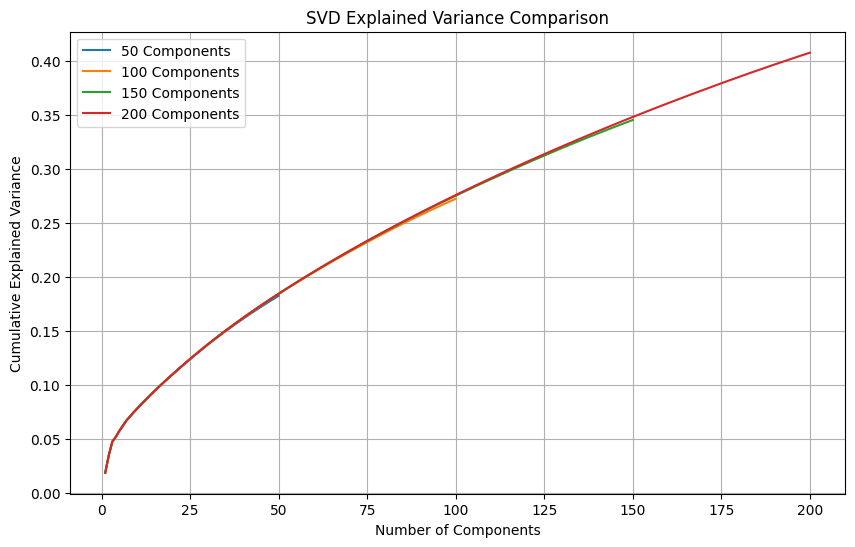

In [10]:
components_list = [50, 100, 150, 200] # Defining different component counts to compare explained variance
variance_curves = {} # Dictionary to store variance curves

plt.figure(figsize=(10,6)) #Initializing the plot figure

for n in components_list: # Looping through each component count
    svd_temp = TruncatedSVD(n_components=n, random_state=42) # Initializing SVD with n components
    svd_temp.fit(X_train_tfidf)
    cumulative_variance = svd_temp.explained_variance_ratio_.cumsum() # Calculating cumulative explained variance
    variance_curves[n] = cumulative_variance
    plt.plot(range(1, n+1), cumulative_variance, label=f"{n} Components") # Plotting the variance curve

plt.title("SVD Explained Variance Comparison")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()


#### Reflection
#### The variance curves for 50, 100, 150, and 200 components show that adding more components keeps increasing the variance captured, but the improvement gets smaller after 100. This means most of the useful information is already contained in the first 100 components. Picking 100 gives us a good middle ground it keeps more detail than 50, but avoids the extra work of going up to 150 or 200. This choice makes the model efficient while still keeping the important patterns in the data.

### Applying SVD with a 100 Components

#### After comparing the cummulative explained variance(which is the total patterns captured by the n svd componenets), we selected 100 components for our dimenstionality reduction.

In [11]:
# Step 4: Dimensionality Reduction with SVD
n_components = 100  # tuning the number of components for SVD
svd = TruncatedSVD(n_components=n_components, random_state=42)  # Initializing SVD with n components

X_train_svd = svd.fit_transform(X_train_tfidf) # Fitting and transforming training data
X_test_svd = svd.transform(X_test_tfidf) # Transforming test data


## 9. Logistic Regression with SVD-Reduced Features

After reducing TF-IDF using SVD, we train a **Logistic Regression** model on the 
dense, lower-dimensional feature set.

Logistic Regression is:
- Robust  
- Interpretable  
- Effective for binary classification  

We evaluate the model using:
- Confusion matrix  
- Accuracy, precision, recall, F1-score  

We later compare this model directly to the Naive Bayes baseline and PCA-reduced model.


#### Using the SVD-reduced features we are training our logist regression model and evaluating how well the model performs in classifying between the negative, positive and neutral tweets.

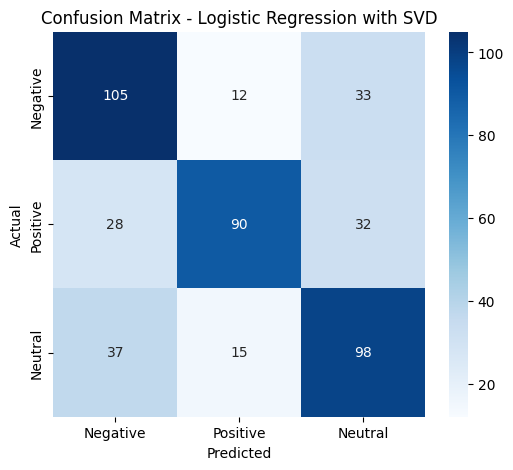

Classification Report - Logistic Regression with SVD
              precision    recall  f1-score   support

           0       0.62      0.70      0.66       150
           1       0.77      0.60      0.67       150
           2       0.60      0.65      0.63       150

    accuracy                           0.65       450
   macro avg       0.66      0.65      0.65       450
weighted avg       0.66      0.65      0.65       450



In [12]:
# Step 5: Logistic Regression with SVD
log_reg_svd = LogisticRegression(max_iter=1000, random_state=42) # Initializing Logistic Regression
log_reg_svd.fit(X_train_svd, y_train) # Fitting model on SVD-transformed training data

y_pred_svd = log_reg_svd.predict(X_test_svd) # Predicting on SVD-transformed test data

# Confusion Matrix
cm_svd = confusion_matrix(y_test, y_pred_svd) # Calculating confusion matrix

plt.figure(figsize=(6,5)) # Setting figure size
sns.heatmap(cm_svd, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Positive','Neutral'],
            yticklabels=['Negative','Positive','Neutral']) # Plotting heatmap
plt.title("Confusion Matrix - Logistic Regression with SVD") # Setting plot title
plt.xlabel("Predicted") # Setting x-axis label
plt.ylabel("Actual") # Setting y-axis label
plt.show()

# Classification Report
print("Classification Report - Logistic Regression with SVD")
print(classification_report(y_test, y_pred_svd))  # Printing classification report


#### Reflection
#### The SVD-reduced features enabled our logistic regression model to achieve a balanced performance across all the three sentiments classes. Although our accuracy was moderate at 65% the model showed a stronger precision for positive sentiments (0.77) and a lower recall of (0.60) suggesting it is more confident when predictied positive classes but misses some instances. The F1-scores was around 63-66% and the neutral and negative classes were reasonable well predicted.

### Comparing Naive Bayes vs Logistic Regression

                       Model  Accuracy  Precision    Recall  F1-Score
0       Naive Bayes (TF-IDF)  0.664444   0.674905  0.664444  0.658373
1  Logistic Regression (SVD)  0.651111   0.662702  0.651111  0.652202


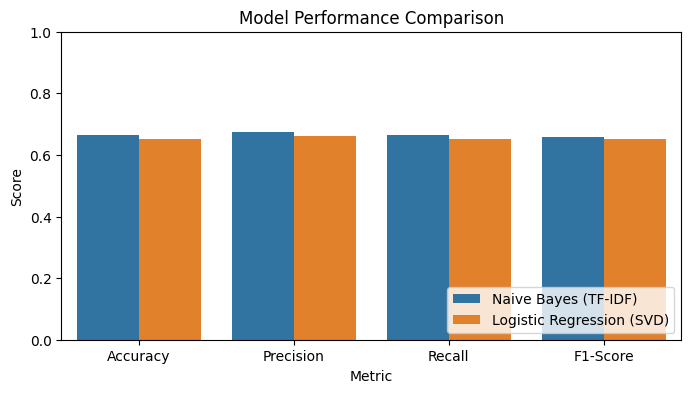

In [13]:
# Collect metrics for both models
metrics = {
    "Model": ["Naive Bayes (TF-IDF)", "Logistic Regression (SVD)"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_nb), # Calculating accuracy for Naive Bayes
        accuracy_score(y_test, y_pred_svd) # Calculating accuracy for Logistic Regression with SVD
    ],
    "Precision": [
        precision_score(y_test, y_pred_nb, average="weighted"), # Calculating precision for Naive Bayes
        precision_score(y_test, y_pred_svd, average="weighted") # Calculating precision for Logistic Regression with SVD
    ],
    "Recall": [
        recall_score(y_test, y_pred_nb, average="weighted"), # Calculating recall for Naive Bayes
        recall_score(y_test, y_pred_svd, average="weighted") # Calculating recall for Logistic Regression with SVD
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_nb, average="weighted"), # Calculating F1-Score for Naive Bayes
        f1_score(y_test, y_pred_svd, average="weighted") # Calculating F1-Score for Logistic Regression with SVD
    ]
}

# Convert to DataFrame for display
comparison_df = pd.DataFrame(metrics) # Creating DataFrame from metrics dictionary

# Show table
print(comparison_df)   # Displaying the comparison DataFrame

# Optional: Pretty visualization
plt.figure(figsize=(8,4)) # Setting figure size
sns.barplot(data=comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), # Melting DataFrame for seaborn
            x="Metric", y="Score", hue="Model") # Plotting barplot
plt.title("Model Performance Comparison") # Setting plot title
plt.ylim(0,1) # Setting y-axis limits
plt.legend(loc="lower right") # Setting legend location
plt.show()


### Reflection
#### Our comparison shows that both models have performed all most the same across all the different calculations. Although we have used a significantly less features for our Logistic regression model it is behind by a small margin. The F1-score are nearly the same which also suggests that both models are balancing precision and recall well. Overall the SVD-based logistic regression model offers another good way of working with large and very sparse text data especially when speed and memory usage are of the factors to be considered.

## 10. Dimensionality Reduction using PCA

Unlike SVD, **PCA requires dense, standardized data**, so we first convert TF-IDF 
to a dense array and apply standardization.

We then reduce to the **same number of components as SVD** to ensure a fair 
comparison between the two dimensionality reduction techniques.

We also visualize PCA's **explained variance curve**, which shows how much of the 
data's variance is preserved across components.

`Standardize the TF-IDF Features`

In [14]:
from sklearn.preprocessing import StandardScaler

# If your TF-IDF matrices are sparse, convert them to dense
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()

# Standardize the data (zero mean, unit variance)
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train_dense)
X_test_std  = scaler.transform(X_test_dense)

print("Standardized shapes:")
print("X_train_std:", X_train_std.shape)
print("X_test_std :", X_test_std.shape)


Standardized shapes:
X_train_std: (1350, 5000)
X_test_std : (450, 5000)


`Apply PCA with same number of components as SVD`

In [15]:
from sklearn.decomposition import PCA

# Use same number of components as your SVD model
# (make sure `svd` was defined earlier in Step 4)
n_components_pca = svd.n_components

print("\n Performing PCA with", n_components_pca, "components.")

pca = PCA(n_components=n_components_pca, random_state=42)

# Fit PCA on the standardized training data
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca  = pca.transform(X_test_std)

print("PCA-transformed shapes:")
print("X_train_pca:", X_train_pca.shape)
print("X_test_pca :", X_test_pca.shape)



 Performing PCA with 100 components.
PCA-transformed shapes:
X_train_pca: (1350, 100)
X_test_pca : (450, 100)


`PCA Variance`

**Variance Ration from PCA**

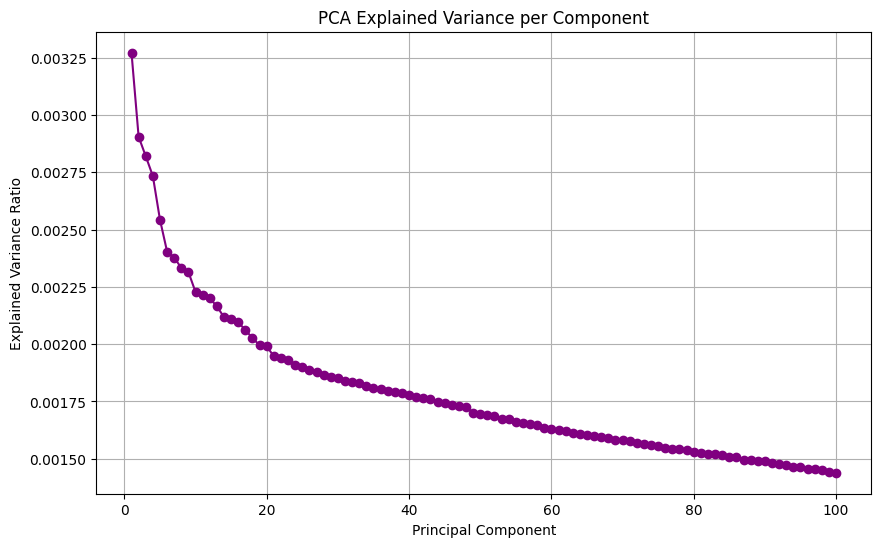

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# variance ratio from PCA
pca_var = pca.explained_variance_ratio_
components = np.arange(1, len(pca_var) + 1)

plt.figure(figsize=(10, 6))
plt.plot(components, pca_var, marker='o', linestyle='-', color='purple')
plt.title("PCA Explained Variance per Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()



_Reflection_

`Principal Component Analysis` reduces high-dimensional data into new axes (components) that capture the greatest amount of variance in the dataset.

 - The first principal component captures the largest possible variance.

 - The second component captures the next largest variance that is orthogonal to the first.

 - Each additional component captures progressively less variance.

The explained variance plot (the above PCA Plot), tells us how much information (or signal) each principal component captures from the original dataset. From the plot:

- There's a  steep drop in the first few components means most information is captured early.

while 

- The long flat tail means later components add very little information.


For Text Data, this is  important because TF-IDF matrices are extremely high-dimensional and sparse. Thus, PCA identifies combinations of features that explain patterns (e.g., word co-occurrence).
This helps us compress thousands of TF-IDF dimensions into a manageable number of components.

**Cumulative Varaince for PCA**

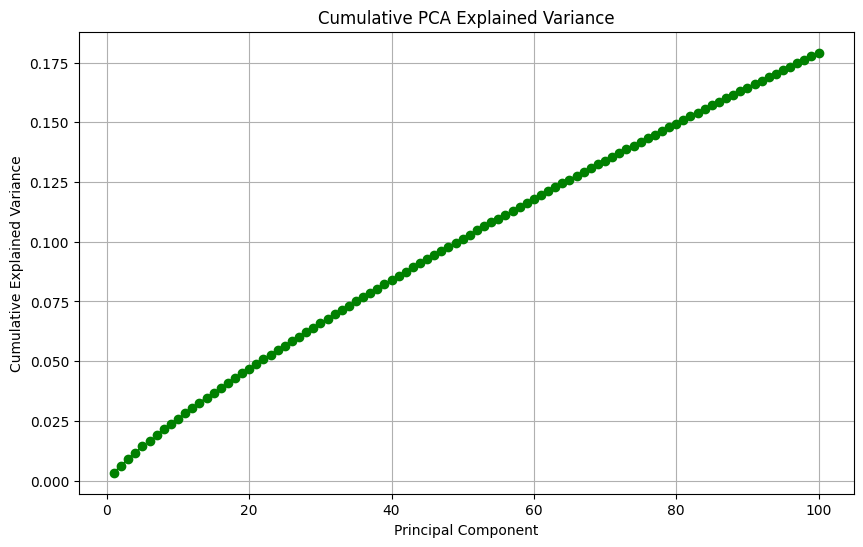

In [21]:
# Cumulative explained variance
cumulative_var = np.cumsum(pca_var)

plt.figure(figsize=(10, 6))
plt.plot(components, cumulative_var, marker='o', linestyle='--', color='green')
plt.title("Cumulative PCA Explained Variance")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


_Reflection_

Cumulative explained variance is crucial because it shows how many components are needed to retain a desired percentage of the total information, helping us decide an optimal number of dimensions to keep without losing important patterns in the data.

The plot above shows that the variance increases very slowly, meaning each principal component contributes only a small amount of information. This indicates that PCA is not capturing strong dominant patterns in the TF-IDF data, which is expected because text data is highly sparse and its variance is spread across many dimensions.

`Compare the PCA vs SVD variance curves`

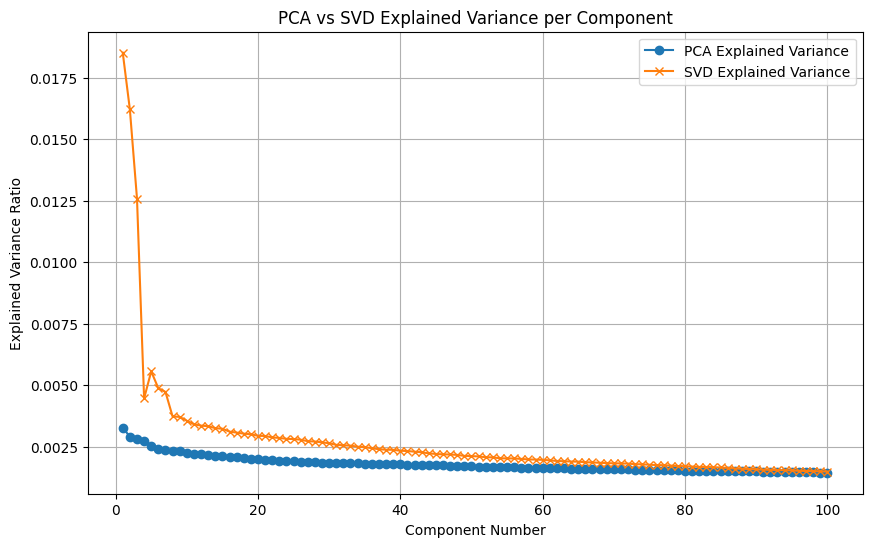

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Explained variance for PCA
pca_variance = pca.explained_variance_ratio_

# SVD explained variance (TruncatedSVD provides this directly)
svd_variance = svd.explained_variance_ratio_

# Number of components (same for both)
components = np.arange(1, len(pca_variance) + 1)

plt.figure(figsize=(10, 6))

plt.plot(components, pca_variance, label="PCA Explained Variance", marker="o")
plt.plot(components, svd_variance, label="SVD Explained Variance", marker="x")

plt.title("PCA vs SVD Explained Variance per Component")
plt.xlabel("Component Number")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.grid(True)
plt.show()


**Reflection**


The PCA always centers and scales the data, so its variance curve usually drops steeply in the first few components.
SVD (used as LSA for TF-IDF) does not require centering and tends to spread variance more smoothly across components.
This demonstrates why SVD is often better suited for sparse text data — it preserves semantic structure without losing information from mean-centering.


## 11. Logistic Regression with PCA-Reduced Features

We train another Logistic Regression model, this time using PCA-transformed features.

This allows us to compare:
- SVD vs PCA performance  
- The effect of dimensionality reduction on classification accuracy  
- Differences in semantic vs variance-based transformations of TF-IDF  

As before, we evaluate using confusion matrices and standard metrics.


`Logistic regression based on the PCA features`

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Train Logistic Regression on PCA-reduced features
logreg_pca = LogisticRegression(max_iter=1000, random_state=42)
logreg_pca.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_pca = logreg_pca.predict(X_test_pca)

# the basic metrics
print("Logistic Regression with PCA - Performance on Test Set")
print("Accuracy:", accuracy_score(y_test, y_pred_pca))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca))


Logistic Regression with PCA - Performance on Test Set
Accuracy: 0.47555555555555556

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.50      0.53       150
           1       0.46      0.44      0.45       150
           2       0.42      0.49      0.45       150

    accuracy                           0.48       450
   macro avg       0.48      0.48      0.48       450
weighted avg       0.48      0.48      0.48       450



`Reflection`



<Figure size 600x500 with 0 Axes>

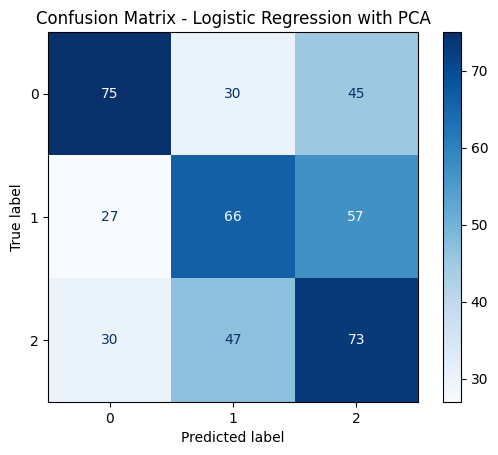

In [19]:
#  the confusion matrix
cm_pca = confusion_matrix(y_test, y_pred_pca)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pca, display_labels=logreg_pca.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression with PCA")
plt.show()

`Reflection`

## 12. Final Comparison of All Models

We summarize and compare the performance of all three models:

1. **Naive Bayes + TF-IDF** (baseline)  
2. **Logistic Regression + SVD**  
3. **Logistic Regression + PCA**

We present:
- A combined performance table  
- Accuracy, precision, recall, and F1-scores  
- A discussion of which model performs best  
- Error analysis (FP/FN patterns)  
- Insights on dimensionality reduction effectiveness

This section forms the core of the presentation and final report.

`Comparison of the Confusion matrices`

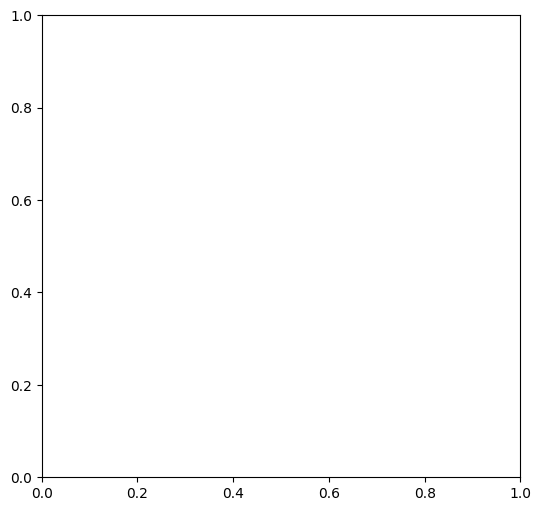

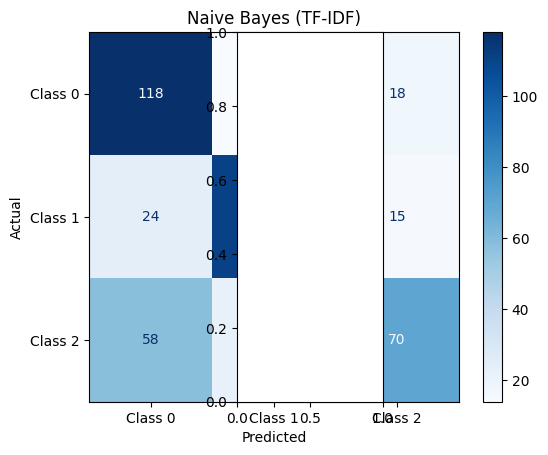

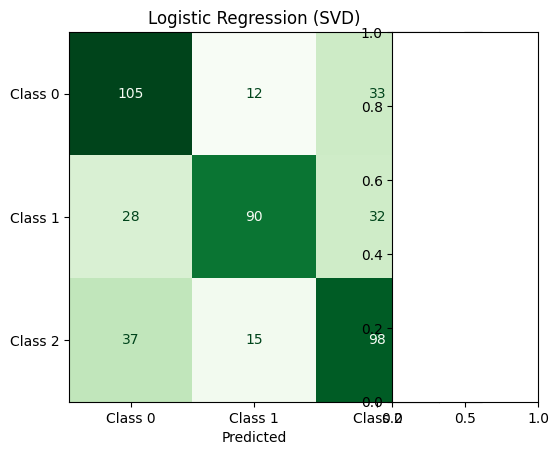

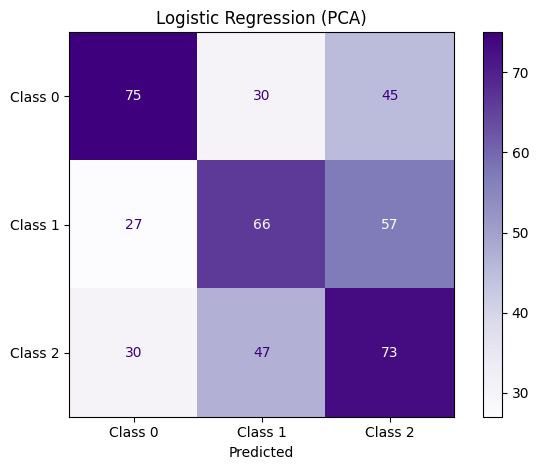

In [ ]:
import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay

# plt.figure(figsize=(21, 6))

# #  Naive Bayes + TF-IDF 
# plt.subplot(1, 3, 1)
# disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Class 0', 'Class 1', 'Class 2'])
# disp_nb.plot(cmap='Blues', values_format='d')
# plt.title("Naive Bayes (TF-IDF)")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")

# #  Logistic Regression + SVD 
# plt.subplot(1, 3, 2)
# disp_svd = ConfusionMatrixDisplay(confusion_matrix=cm_svd, display_labels=['Class 0', 'Class 1', 'Class 2'])
# disp_svd.plot(cmap='Greens', values_format='d')
# plt.title("Logistic Regression (SVD)")
# plt.xlabel("Predicted")
# plt.ylabel("")

# # Logistic Regression + PCA 
# plt.subplot(1, 3, 3)
# disp_pca = ConfusionMatrixDisplay(confusion_matrix=cm_pca, display_labels=['Class 0', 'Class 1', 'Class 2'])
# disp_pca.plot(cmap='Purples', values_format='d')
# plt.title("Logistic Regression (PCA)")
# plt.xlabel("Predicted")
# plt.ylabel("")

# plt.tight_layout()
# # plt.show()


`Comparicson Performance Report`

 **Combined Model Performance Comparison Table**

| **Model**                     | **Accuracy** | **Precision (Weighted)** | **Recall (Weighted)** | **F1-Score (Weighted)** |
| ----------------------------- | ------------ | ------------------------ | --------------------- | ----------------------- |
| **Naive Bayes (TF-IDF)**      | 0.66         | 0.67                     | 0.66                  | 0.66                    |
| **Logistic Regression (SVD)** | 0.65         | 0.66                     | 0.65                  | 0.65                    |
| **Logistic Regression (PCA)** | 0.48         | 0.48                     | 0.48                  | 0.48                    |



**Reflection**

* Naive Bayes delivered the **best overall performance**, slightly outperforming SVD in all metrics.
* Logistic Regression with SVD performed **almost equally**, showing that semantic dimensionality reduction kept most useful information.
* PCA produced the **weakest results**, confirming that variance-based PCA is not suitable for sparse TF-IDF text data because it loses important semantic relationships.

## 13. Conclusion

We reflect on the overall performance of the three models and highlight:

- Which approach yields the highest accuracy  
- Whether dimensionality reduction helps or hurts performance  
- Which method (SVD or PCA) is more suitable for text data  
- Strengths and weaknesses of each model  
- Observations from Delta vs United sentiment trends  
- Suggestions for future improvements (deep learning, more features, larger dataset)

This conclusion ties together all analysis and supports the final presentation.

### References

**1.**
Jolliffe, I. T., & Cadima, J. (2016). *Principal component analysis: A review and recent developments*. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 374(2065), 20150202. [https://doi.org/10.1098/rsta.2015.0202](https://doi.org/10.1098/rsta.2015.0202)

**2.**
Shlens, J. (2014). *A tutorial on principal component analysis*. arXiv. [https://arxiv.org/abs/1404.1100](https://arxiv.org/abs/1404.1100)

**3.**
Abdi, H., & Williams, L. J. (2010). *Principal component analysis*. Wiley Interdisciplinary Reviews: Computational Statistics, 2(4), 433–459. [https://doi.org/10.1002/wics.101](https://doi.org/10.1002/wics.101)

---